In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import scipy as scip
from mpl_toolkits.axes_grid1 import make_axes_locatable

from EWOthello.mingpt.probe_model import BatteryProbeClassification
from EWOthello.mingpt.utils import set_seed
from EWOthello.mingpt.model import GPTConfig,  GPTforProbeIA, GPTforProbeIA_ModV1
from EWOthello.data.othello import * 
from EWOthello.mingpt.dataset import CharDataset 
import EWOthello.utils.plot_helpers as plt_utils
from EWOthello.mingpt.utils import  intervene

set_seed(44)
print(torch.cuda.is_available())
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(device))

/home/deanhazineh/anaconda3/envs/emergent_world/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
NVIDIA GeForce RTX 3090 Ti


In [2]:
# Get a the game dataset
othello = get(ood_num=-1, data_root=None, num_preload=1) # 11 corresponds to over 1 million games
game_dataset = CharDataset(othello) 
print("Data Loaded \n")

Max num files: 230; Use_num: 1
['gen10e5__20220324_165952.pickle']


Mem Used: 0.4334 GB: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

Deduplicating...


Deduplicating finished with 99999 games left
Using 20 million for training, 0 for validation
Dataset created has 99999 sequences, 61 unique words.
Data Loaded 



In [6]:
def run_game_intervention(x, tbf, number_moves, intervention_moves, probe_set, layer_s, layer_e, htd):
    x = x.to(device)
    # Define the board that is passed in
    ab = OthelloBoardState()
    ab.update(tbf[:number_moves], prt=False)
    init_board = np.array(ab.get_state()).reshape(8,8)

    idx_of_interest = number_moves-1 # This corresponds to the index for the next game-move
    padding = torch.zeros(2).cuda() # Add in center two tiles with zero padding because output skips over them
    mconf = GPTConfig(vocab_size=61, block_size=59, n_layer=8, n_head=8, n_embd=512)
    model = GPTforProbeIA_ModV1(mconf)
    model.load_state_dict(torch.load("../EWOthello/ckpts/gpt_synthetic.ckpt"))
    model.eval()
    model = model.to(device) 

    # Compute the logits with no intervention
    intv_activation = model.forward_1st_stage(-1, x[None, :])[0]
    init_pred, _ = model.predict(intv_activation)
    init_pred = init_pred[idx_of_interest, 1:]
    init_pred = torch.cat([init_pred[:27], padding, init_pred[27:33], padding, init_pred[33:]], dim=0)
    init_pred = init_pred.detach().cpu().reshape(8,8).numpy()

    # Compute the intervention and the new predictions
    interv_boards = []
    interv_preds = []
    actions=[]
    for square in intervention_moves:
        wtd = {}
        wtd["intervention_position"] = square
        tile_number = permit(wtd["intervention_position"])
        r, c = tile_number // 8, tile_number % 8
        wtd["intervention_from"] = ab.state[r, c] + 1
        wtd["intervention_to"] = 2 - wtd["intervention_from"]
        
        action="No Change" if wtd["intervention_from"] == wtd["intervention_to"] else "Flipped"
        actions.append(f"pos: {square} state {action}")
        
        # Get the layer activation and use probe to get the board state
        intv_activation = model.forward_1st_stage(layer_s, x[None, :])[0]
        board, _ = probe_set[0](intv_activation)    
        board = torch.argmax(board, -1, keepdim=False)
        
        # Update activation
        post_intv_activation = intervene(probe_set[0], intv_activation.clone()[idx_of_interest,:], board[idx_of_interest,:], wtd, htd, plot=True)
        intv_activation[idx_of_interest, :] = post_intv_activation

        board, _ = probe_set[0](intv_activation)    
        board = torch.argmax(board, -1, keepdim=False)
        board = board[idx_of_interest,:].detach().cpu().reshape(8,8).numpy()
        interv_boards.append(board[None])
        
        # Update the downstream activations
        intv_activation = model.forward_2nd_stage(intv_activation[None], layer_s, -1)[0][0]
        post_intv_pred, _ = model.predict(intv_activation)
        post_intv_pred = post_intv_pred[idx_of_interest, 1:]
        post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)
        post_intv_pred = post_intv_pred.detach().cpu().reshape(8,8).numpy()
        interv_preds.append(post_intv_pred[None])
        
    if len(interv_boards)==1:
        return init_board, init_pred, interv_boards[0], interv_preds[0], actions
    else:
        return init_board, init_pred, np.concatenate(interv_boards, axis=0), np.concatenate(interv_preds, axis=0), actions

In [7]:
probesLinear = [] # We need the pre-trained probes for the layer we want and all layers after it according to their theory
layer_s = 6
layer_e = 8+1
checkpoint_path = "../EWOthello/ckpts/DeanModels/"

for layer in range(layer_s, layer_e):
    print(f"Loading Pre-trained probe for layer: {layer}")
    probe = BatteryProbeClassification(device, probe_class=3, num_task=64, input_dim=512)
    probe.load_state_dict(torch.load(checkpoint_path + f"linearProbe_Map_new_8L8H_GPT_Layer{layer}.ckpt"))
    probe.eval()
    probesLinear.append(probe)

# Game sequence from the dataset chosen by index=#
index = 499
x, _ = game_dataset[index]
tbf = [game_dataset.itos[_] for _ in x.tolist()]
number_moves = 5
probe_set = probesLinear
htd = {"lr": 1e-3, "steps": 1000, "reg_strg": 0.2}
intervention_moves = ["c3"]
init_board, init_pred, interv_boards, interv_preds, actions = run_game_intervention(x, tbf, number_moves, intervention_moves, probe_set, layer_s, layer_e, htd)

Loading Pre-trained probe for layer: 6
Loading Pre-trained probe for layer: 7
Loading Pre-trained probe for layer: 8
c3 Sucessfully intervened!


-0.14959183 0.13405734


Text(0, 0.5, 'Change In Next-Move Prob.')

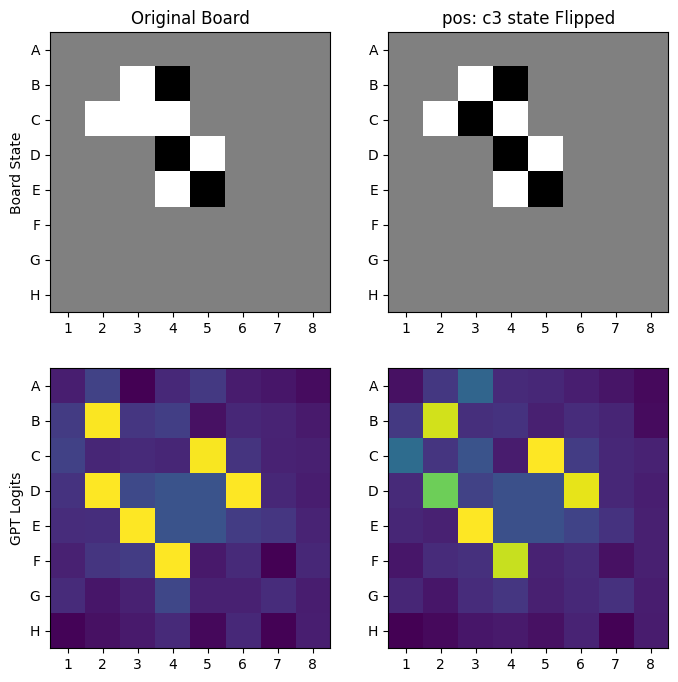

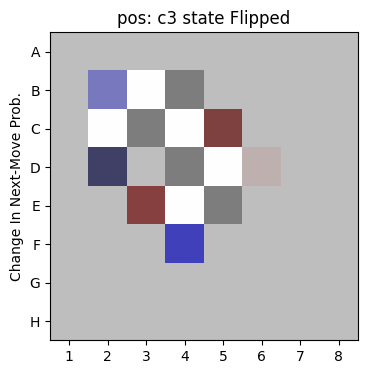

In [8]:
plot_boards = np.concatenate((init_board[None], interv_boards), axis=0)
plot_logits = np.concatenate((init_pred[None], interv_preds), axis=0)
#prob_diff = interv_preds - init_pred[None] 
prob_diff = scip.special.softmax(interv_preds) - scip.special.softmax(init_pred[None])
print(np.min(prob_diff), np.max(prob_diff))

### PLot the gameboard
num_plot = plot_boards.shape[0]
fig = plt.figure(figsize=(4*num_plot, 8))
ax = plt_utils.addAxis(fig,2,num_plot)
for i in range(num_plot):
    ax[i].imshow(plot_boards[i], cmap="gray")
    ax[i+num_plot].imshow(plot_logits[i])
plt_utils.format_ax_boardImage(ax)
for i in range(num_plot):
    ax[0].set_title("Original Board") if i==0 else ax[i].set_title(actions[i-1])
ax[0].set_ylabel("Board State")
ax[num_plot].set_ylabel("GPT Logits")

### Plot the change plot
num_interv = len(intervention_moves)
fig = plt.figure(figsize=(4*num_interv, 4))
ax = plt_utils.addAxis(fig,1,num_interv)
for i in range(num_interv):
    ax[i].imshow(interv_boards[i], cmap="gray")
    ax[i].set_title(actions[i])
    im = ax[i].imshow(prob_diff[i], alpha=0.5, cmap="seismic", norm=TwoSlopeNorm(0))
    #plt_utils.addColorbar(fig, ax[i], im)
plt_utils.format_ax_boardImage(ax)
ax[0].set_ylabel("Change In Next-Move Prob.")